# Medical Cost Prediction

## Objective
Predict the **medical insurance cost** for individuals based on their demographic and health-related information.

## Dataset Overview
The dataset includes the following features:
- Age
- Sex
- BMI (Body Mass Index)
- Number of children
- Smoker (yes/no)
- Region
- Charges (target variable)

## Workflow
1. Load and explore the dataset
2. Preprocess the data (encoding, scaling)
3. Train regression models
4. Evaluate model performance

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
df = pd.read_csv("../artifacts/raw.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis (EDA)

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.describe(include="O")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [6]:
df["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [7]:
# Missing Values
null_values = df.isnull().sum()

zero_count = {}

for column in df.columns:
    zero_count[column] = len(df[df[column] == 0])

print(f"Null values in the Dataframe: \n{null_values}\n")
print(f"Missing Values in form of 0 entries: ")
for key, value in zero_count.items():
    print(f"{key} : {value}")

Null values in the Dataframe: 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Missing Values in form of 0 entries: 
age : 0
sex : 0
bmi : 0
children : 574
smoker : 0
region : 0
charges : 0


### People can have no children

In [8]:
def plot_distribution(df: pd.DataFrame, feature: str):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=feature, bins=30, kde=True)
    plt.title("Distribution of {feature}")
    plt.xlabel(feature)

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x=feature)
    plt.tight_layout()
    plt.show()

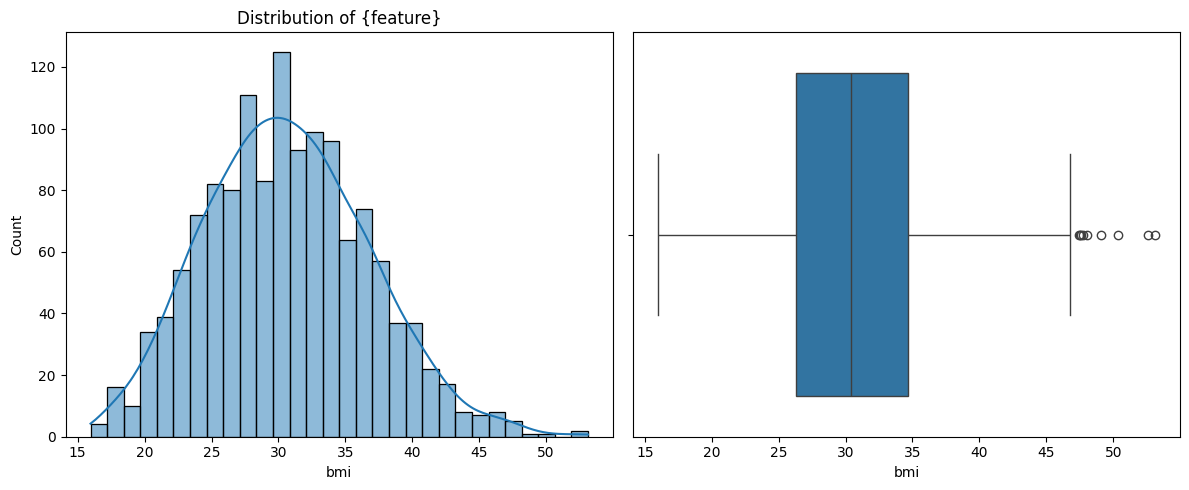

In [9]:
plot_distribution(df, 'bmi')

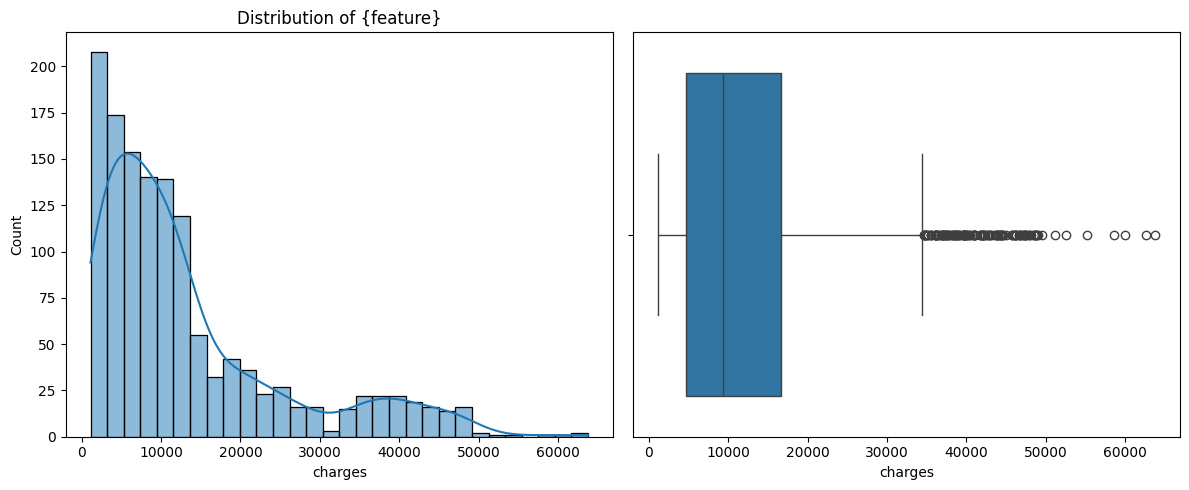

In [10]:
plot_distribution(df, 'charges')

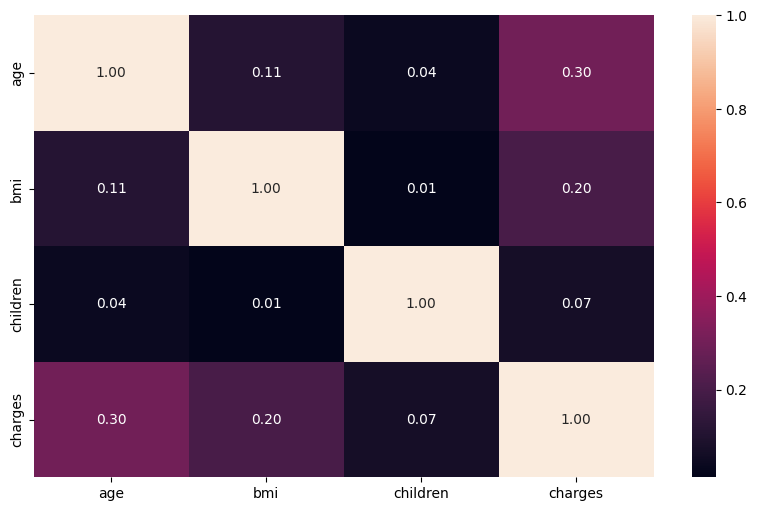

In [11]:
plt.figure(figsize=(10, 6))
numerical_columns = df.select_dtypes(include="number").columns
sns.heatmap(df[numerical_columns].corr(), annot=True, fmt=".2f")
plt.show()

## Data Preprocessing

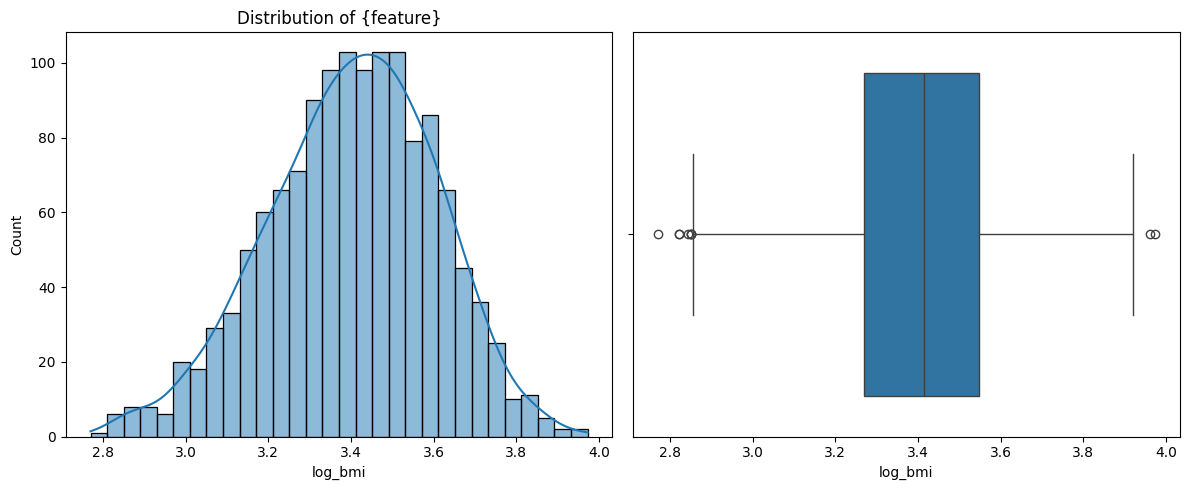

In [12]:
#this did make the distribution somewhat left skewed but it reduced the no. of outliers

df['log_bmi'] = np.log1p(df['bmi'])
plot_distribution(df, 'log_bmi')

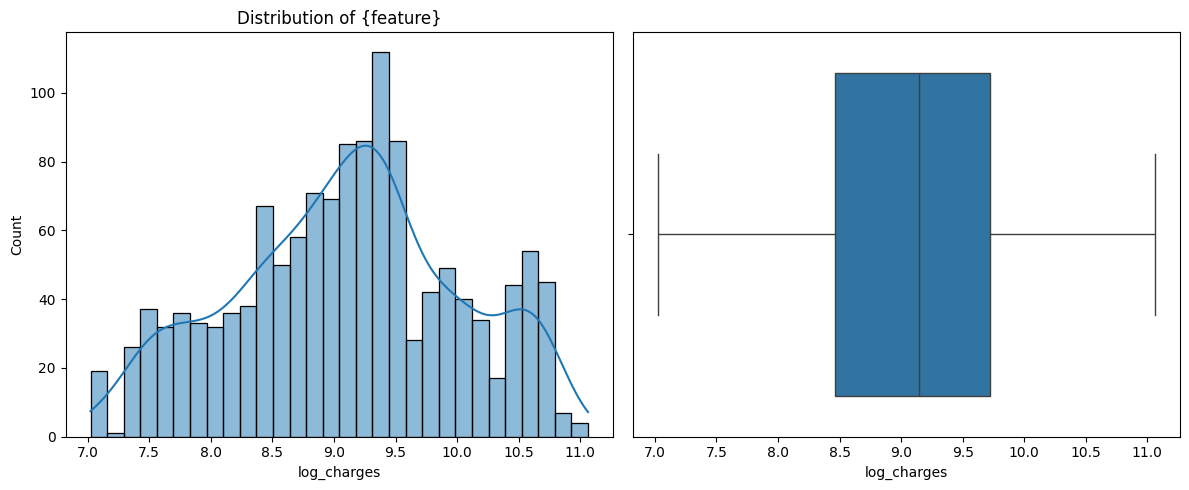

In [17]:
# This made the distribution a gaussian one and removed all outliers
df['log_charges'] = np.log1p(df['charges'])
plot_distribution(df, 'log_charges')

In [38]:
df.drop(columns=["bmi", "charges"], inplace=True)

In [39]:
# Encode categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# Split into features and target

# Converted Categorical smoker to Numerical feature
df["smoker_binary"] = df["smoker"].map({"yes": 1, "no":0})

#Interaction Term
df["age_smoke"] = df["smoker_binary"] * df["age"]

X = df.drop(columns=["log_charges", "smoker"])
y = df["log_charges"]

numerical_features = X.select_dtypes(include="number").columns
categorical_features = X.select_dtypes(include="object").columns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Original Values since I log them to fit Gaussian distribution and to remove outliers
y_test_original = np.expm1(y_test)

#Preprocessor for Scaling and OneHot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ], 
    remainder="passthrough"
)


## Model Training

In [137]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import HuberRegressor


model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Train a linear regression model
print("Fitting the model pipeline")
model_pipeline.fit(X_train, y_train)
print("Model Trained")


# Make predictions
y_pred = model_pipeline.predict(X_test)

# Inverse transform the predictions back to the original scale
y_pred_transformed = np.expm1(y_pred)



Fitting the model pipeline
Model Trained


In [138]:
print(y_pred_transformed[:5])
print(y_test_original.head())

[ 9450.44152525  5439.34286043 33942.11853719  9688.60525995
 22649.13662566]
764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
Name: log_charges, dtype: float64


## Evaluation

In [139]:
# Evaluation metrics
mse_error = mean_squared_error(y_test_original, y_pred_transformed)
rms_error = np.sqrt(mse_error)
r2Score = r2_score(y_test_original, y_pred_transformed)

print("\n --- Evaluation Results --- ")
print(f"Root Mean Sqaured Error: ${rms_error:.2f}\nr2 Score: {r2Score:.4f}\nMean Squared Error: ${mse_error:.2f}")


 --- Evaluation Results --- 
Root Mean Sqaured Error: $5651.86
r2 Score: 0.7942
Mean Squared Error: $31943536.47


## Cross-Validation
    Provides better generalization of the error for when model is in production.

In [127]:
from sklearn.model_selection import KFold, cross_validate

scaler = StandardScaler()
one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

df_cv = df.copy()

df_cv.drop(columns=["smoker"], inplace=True)

df_cv[numerical_features] = scaler.fit_transform(df_cv[numerical_features])
df_one_hot_encoded = one_hot.fit_transform(df_cv[categorical_features])

df_one_hot_encoded = pd.DataFrame(df_one_hot_encoded, columns= one_hot.get_feature_names_out())

df_cv = df_cv.drop(columns= categorical_features)

df_cv = pd.concat([df_cv, df_one_hot_encoded], axis=1)

X_cv = df_cv.drop(columns=["log_charges"])
y_cv = df_cv["log_charges"]

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y_cv, test_size=0.2, random_state=42)

In [132]:
from sklearn.metrics import make_scorer

cv_strategy = KFold(n_splits=10, shuffle=True, random_state=42)

def rmse_scorer(y_true_transformed, y_pred_transformed):
    y_true_original = np.expm1(y_true_transformed)
    y_pred_original = np.expm1(y_pred_transformed)
    return np.sqrt(mean_squared_error(y_true_original, y_pred_original))

rmse_custom_scorer = make_scorer(rmse_scorer, greater_is_better=False)

cv_results = cross_validate(
    estimator=LinearRegression(),
    X=X_train_cv,
    y=y_train_cv,
    cv=cv_strategy,
    scoring={
        "r2": "r2", #R2 works fine with transformed y
        "rmse": rmse_custom_scorer
    },
    n_jobs=-1
)

In [133]:
print("\n--- Cross-Validation Results ---")
print(f"Mean R2 (Validation): {np.mean(cv_results['test_r2']):.4f} (+/- {np.std(cv_results['test_r2']):.4f})")
print(f"Mean RMSE (Validation): ${np.mean(-cv_results['test_rmse']):,.2f} (+/- ${np.std(cv_results['test_rmse']):,.2f})")
print("\nIndividual fold results:")
for i in range(cv_strategy.get_n_splits()):
    print(f"Fold {i+1}: R2={cv_results['test_r2'][i]:.4f}, RMSE=${-cv_results['test_rmse'][i]:,.2f}")



--- Cross-Validation Results ---
Mean R2 (Validation): 0.7907 (+/- 0.0657)
Mean RMSE (Validation): $6,252.68 (+/- $757.01)

Individual fold results:
Fold 1: R2=0.7901, RMSE=$6,486.26
Fold 2: R2=0.6755, RMSE=$7,066.61
Fold 3: R2=0.7881, RMSE=$7,759.00
Fold 4: R2=0.8477, RMSE=$5,584.01
Fold 5: R2=0.7733, RMSE=$5,714.77
Fold 6: R2=0.9073, RMSE=$5,303.63
Fold 7: R2=0.7165, RMSE=$6,612.90
Fold 8: R2=0.8564, RMSE=$6,717.53
Fold 9: R2=0.7410, RMSE=$5,722.95
Fold 10: R2=0.8114, RMSE=$5,559.14


In [130]:
def plot_actual_vs_predicted(true_values, predicted_values):
    plt.figure(figsize=(14, 6))

    plt.subplot(1,2,1)
    sns.scatterplot(x=true_values, y=predicted_values, color='blue', alpha=0.7)

    # Add a diagonal line representing perfect predictions
    min_val = min(np.min(true_values), np.min(predicted_values))
    max_val = max(np.max(true_values), np.max(predicted_values))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

    plt.title('True Values vs. Predicted Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # This plot helps visualize heteroscedasticity (error variance not constant)
    # Plotting residual vs predicted values
    residuals = true_values - predicted_values

    plt.subplot(1,2,2)
    sns.scatterplot(x=predicted_values, y=residuals, color='green', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals') # Line at y=0 for perfect prediction

    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (True - Predicted)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

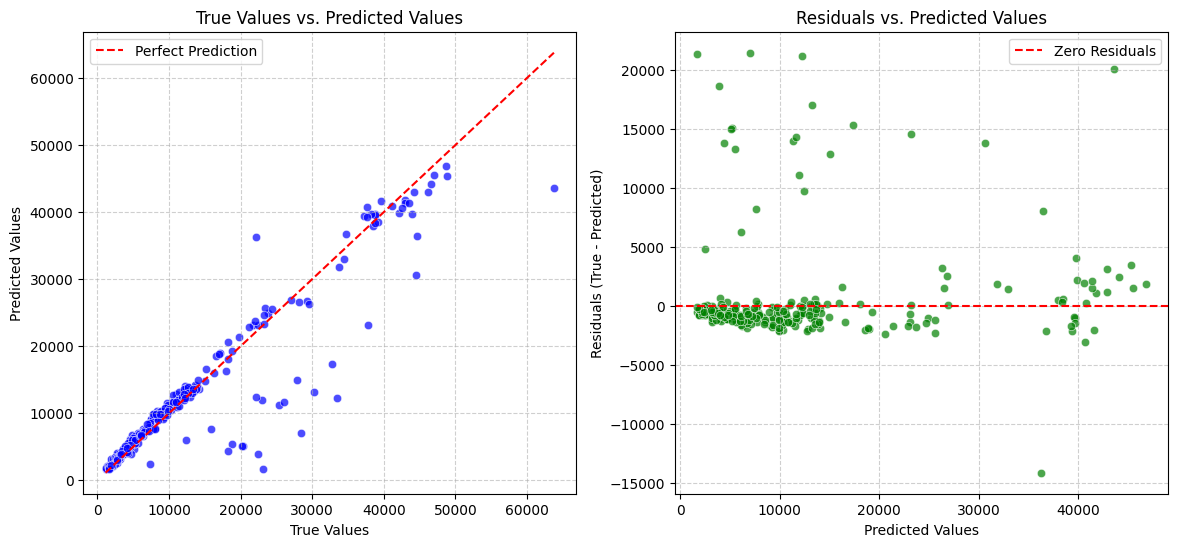

In [131]:
plot_actual_vs_predicted(y_test_original, y_pred_transformed)

## Conclusion
- A linear regression model was built to predict medical charges. This model itself is quite good for a Linear model as it capture 79% of the variance with an error of about $7000.
- Further performance improvement could be achieved using non-linear models like Decision Trees, Random Forest, or Gradient Boosting.